# Воссоздание функционала СППР «ИГЛА»

В этом блокноте мы воссоздаём весь ключевой функционал программы **«ИГЛА»** и проверяем наши результаты на каждом этапе.

---

## 📑 Структура блокнота

1. [Создание групп](#1-создание-групп)  
2. [Добавление концептов](#2-добавление-концептов)  
3. [Пример создания карты «Инновации»](#3-пример-создания-карты-инновации)  
4. [Визуальное отображение](#4-визуальное-отображение)  
5. [Экспорт данных](#5-экспорт-данных)  
6. [Транзитивно замкнутые матрицы](#6-транзитивно-замкнутые-матрицы)  
7. [Матрица влияния](#7-матрица-влияния)  
8. [Матрицы консонанса и диссонанса](#8-матрицы-консонанса-и-диссонанса)  
9. [Системные показатели](#9-системные-показатели)  
10. [Матрицы взаимного положительного и отрицательного влияния](#10-матрицы-взаимного-положительного-и-отрицательного-влияния)  
11. [Консонанс и диссонанс взаимного влияния](#11-консонанс-и-диссонанс-взаимного-влияния)  
12. [Альфа-срез](#12-альфа-срез)
 

---

> **Примечание:**  
> На каждом шаге мы приводим как **теоретическое обоснование**, так и **практическую реализацию** с проверкой на соответствие результатам СППР «ИГЛА».  
>  
> **Переходы:** для быстрого перемещения по разделам используйте оглавление выше или закладки в Jupyter Notebook.  
>  
> **Дальнейшие шаги:** после завершения раздела со статистическим моделированием я перешёл к динамическому, скоро будет готов)


## 1. Создание групп

В этом блоке мы создаём пустую таблицу `groups` для хранения информации о группах концептов и определяем функцию `add_group`, которая:

- Автоматически присваивает группе порядковый номер (`Номер`).
- Принимает на вход `name` — название группы и необязательный `description` — её описание.
- Добавляет новую запись в DataFrame `groups`, сохраняя все ранее созданные группы.

In [1]:
import pandas as pd

# Инициализация таблицы групп
groups = pd.DataFrame(columns=['Номер', 'Наименование', 'Описание'])

# Функция добавления группы
def add_group(name, description=None):
    """
    Добавляет новую группу в таблицу groups.
    
    Параметры:
    - name: строка, название группы
    - description: строка или None, необязательное описание группы
    """
    global groups
    new_group = {
        'Номер': len(groups) + 1,
        'Наименование': name,
        'Описание': description
    }
    groups = pd.concat([groups, pd.DataFrame([new_group])], ignore_index=True)

## 2. Добавление концептов

В этом блоке мы создаём структуру для хранения наших концептов и матрицу влияний, которая будет расширяться автоматически при добавлении новых концептов:

1. **`concepts`** — пустой `DataFrame` с колонками:
   - `№` — порядковый номер концепта  
   - `Название концепта` — текстовое имя  
   - `Тип концепта` — например, «фактор», «событие» и т.д.  
   - `Целевой` — булево, является ли концепт целевым  
   - `Группа` — номер группы, к которой относится концепт  
   - `Описание концепта` — дополнительная справочная информация  

2. **`cognitive_matrix`** — начальная матрица влияний размером 0×0 (будет увеличиваться до n×n).

3. **Функция `add_concept(...)`**:
   - Принимает параметры `name`, `concept_type`, `is_target`, `group_id`, `description`.  
   - Добавляет новый концепт в `concepts`, присваивая ему следующий порядковый номер.  
   - Расширяет `cognitive_matrix` до размера n×n, заполняя новые строки и столбцы нулями и сохраняя старые значения влияний.  

In [2]:
import numpy as np
import pandas as pd

# Инициализация таблицы концептов
concepts = pd.DataFrame(columns=[
    '№', 'Название концепта', 'Тип концепта', 
    'Целевой', 'Группа', 'Описание концепта'
])

# Инициализация матрицы влияний
cognitive_matrix = np.zeros((0, 0))

# Функция добавления концепта
def add_concept(name, concept_type, is_target, group_id=None, description=None):
    """
    Добавляет новый концепт в таблицу concepts и расширяет cognitive_matrix.

    Параметры:
    - name: str, название концепта
    - concept_type: str, тип концепта (например, 'фактор' или 'событие')
    - is_target: bool, является ли концепт целевым
    - group_id: int или None, номер группы
    - description: str или None, описание концепта
    """
    global concepts, cognitive_matrix
    
    # Создаем запись для нового концепта
    new_concept = {
        '№': len(concepts) + 1,
        'Название концепта': name,
        'Тип концепта': concept_type,
        'Целевой': is_target,
        'Группа': group_id,
        'Описание концепта': description
    }
    # Добавляем в DataFrame
    concepts = pd.concat([concepts, pd.DataFrame([new_concept])], ignore_index=True)
    
    # Расширяем матрицу влияний до нового размера n×n
    n = len(concepts)
    new_matrix = np.zeros((n, n))
    if n > 1:
        new_matrix[:n-1, :n-1] = cognitive_matrix
    cognitive_matrix = new_matrix

**Установка веса влияния между концептами**

Функция `set_influence` позволяет задать **направленную связь** между двумя концептами, обновляя соответствующую ячейку в `cognitive_matrix`:

- **`source_id`** (int) — номер (№) концепта-источника  
- **`target_id`** (int) — номер (№) концепта-приёмника  
- **`weight`** (float) — сила влияния (положительная или отрицательная)

После вызова:
```python
set_influence(2, 5, 0.7)

In [3]:
def set_influence(source_id, target_id, weight):
    """
    Устанавливает вес влияния от концепта source_id к концепту target_id.

    Параметры:
    - source_id: int, номер концепта-источника (1…n)
    - target_id: int, номер концепта-приёмника (1…n)
    - weight: float, значение влияния (положительное или отрицательное)
    """
    cognitive_matrix[source_id-1][target_id-1] = weight

## 3. Пример создания карты «Инновации»

В этой ячейке мы демонстрируем пример наполнения когнитивной карты для предметной области «Инновации», точно повторяя последовательность действий в СППР «ИГЛА»:

1. **Добавление групп**  
   - Используем функцию `add_group` для создания тематических разделов:  
     - Персонал  
     - Маркетинг  
     - НИОКР  
     - Предприятие  

2. **Добавление концептов**  
   - С помощью `add_concept` добавляем 19 концептов с указанием:  
     - Названия  
     - Типа (управляемый/неуправляемый/наблюдаемый)  
     - Флага «Целевой» (1 — целевой, 0 — нет)  
     - Номера группы  
     - Дополнительного описания  

3. **Установка влияний**  
   - Функция `set_influence(source_id, target_id, weight)` задаёт направленные связи между концептами:  
     - `source_id` → `target_id` с указанным весом (положительное или отрицательное влияние).  
   - Последовательно задаются основные связи, отражающие логику инновационных процессов:  
     - Мотивация персонала → Корпоративная культура  
     - Исследования маркетинга → Продажи новой продукции  
     - Инвестиции и риск → Разработка и внедрение продукта  
     - и т.д.

После выполнения этой ячейки структура `concepts` и `cognitive_matrix` совпадёт с тем, что создаёт программа «ИГЛА» для этой карты, — можно переходить к визуализации и анализу.  

In [4]:
# Добавление групп
add_group("Общая")

# Добавление концептов
add_concept("Заинтересованность руковолителя", "неуправляемый", 0, 1)
add_concept("Заинтересованность дипломника", "неуправляемый", 0, 1)
add_concept("Уровень подготовки дипломника", "неуправляемый", 0, 1)
add_concept("Качество дипломной работы", "неуправляемый", 1, 1)
add_concept("Уровень организации и контроля дипломного проектирования", "управляемый", 0, 1)
add_concept("Доля формальной составляющей в процессе дипломного проектирования", "управляемый", 0, 1)
add_concept("Сроки окончания дипломного проектирования", "неуправляемый", 1, 1)

# Установка влияний между концептами
set_influence(1, 5, 0.8)
set_influence(2, 4, 0.9)
set_influence(2, 7, -0.45)
set_influence(3, 4, 0.425)
set_influence(3, 6, -0.3)
set_influence(3, 7, -0.85)
set_influence(4, 5, -0.17)
set_influence(5, 7, -0.5)
set_influence(6, 2, -0.3714)
set_influence(6, 4, -0.2143)
set_influence(6, 5, -0.1129)
set_influence(6, 7, -0.8)

In [5]:
# # Добавление групп
# add_group("Персонал")
# add_group("Маркетинг")
# add_group("НИОКР")
# add_group("Предприятие")

# # Добавление концептов
# add_concept("Квалификация персонала", "неуправляемый", 0, 1)
# add_concept("Степень инновационности корпоративной культуры", "неуправляемый", 0, 1)
# add_concept("Интенсивность мотивационных мер", "управляемый", 0, 1)
# add_concept("Сопротивление изменениям", "неуправляемый", 0, 1)
# add_concept("Эффективность труда", "неуправляемый", 0, 1, "В первую очередь сотрудников, занятых в инновационном процессе - инженерно-технических работников")
# add_concept("Уровень предварительных маркетинговых исследований", "управляемый", 0, 2)
# add_concept("Усилия по продвижению новой продукции на рынок", "управляемый", 0, 2)
# add_concept("Объем продаж новой продукции", "неуправляемый", 1, 2)
# add_concept("Время разработки новой продукции", "неуправляемый", 1, 2)
# add_concept("Степень соответствия новой продукции заявленным характеристикам", "неуправляемый", 1, 2)
# add_concept("Степень новизны разработок", "неуправляемый", 0, 3)
# add_concept("Количество новых разработок", "управляемый", 0, 3)
# add_concept("Синергия подразделений", "неуправляемый", 0, 4)
# add_concept("Горизонт планирования стратегии развития предприятия", "управляемый", 0, 4)
# add_concept("Необходимость изменения типа организационной структуры", "неуправляемый", 0, 4)
# add_concept("Инвестиционная привлекательность", "наблюдаемый", 0, 4)
# add_concept("Конкурентоспособность предприятия", "неуправляемый", 1, 4)
# add_concept("Резерв ресурсов", "неуправляемый", 0, 4)
# add_concept("Рентабельность новой продукции", "неуправляемый", 1, 4)

# # Установка влияний между концептами
# set_influence(2, 1, 0.5)
# set_influence(3, 2, 0.9)
# set_influence(2, 4, -0.7)
# set_influence(1, 5, 0.7)
# set_influence(3, 5, 0.7)
# set_influence(4, 6, -0.4)
# set_influence(4, 7, -0.5)
# set_influence(7, 8, 0.8)
# set_influence(5, 9, -0.6)
# set_influence(7, 9, 0.6)
# set_influence(10, 8, 0.7)
# set_influence(1, 10, 0.9)
# set_influence(11, 10, -0.6)
# set_influence(6, 11, 0.5)
# set_influence(12, 9, 0.8)
# set_influence(11, 12, -0.5)
# set_influence(13, 10, 0.5)
# set_influence(2, 13, 0.5)
# set_influence(11, 13, -0.5)
# set_influence(14, 3, -0.2)
# set_influence(14, 12, 0.5)
# set_influence(15, 2, -0.8)
# set_influence(15, 4, 0.5)
# set_influence(11, 15, 0.6)
# set_influence(14, 15, -0.2)
# set_influence(6, 16, 0.7)
# set_influence(14, 16, 0.8)
# set_influence(17, 14, 0.8)
# set_influence(11, 17, 0.6)
# set_influence(18, 9, -0.7)
# set_influence(5, 18, -0.2)
# set_influence(16, 18, 0.9)
# set_influence(19, 17, 0.9)
# set_influence(5, 19, 0.8)
# set_influence(8, 19, 0.9)
# set_influence(9, 19, -0.6)
# set_influence(13, 19, 0.5)

## 4. Визуальное отображение

В этом блоке мы строим **ориентированный граф** исходной когнитивной карты на основе матрицы `cognitive_matrix`, без применения α-среза:

1. **Создание графа**  
   - `G = nx.DiGraph()` — направленный граф NetworkX  
   - По `concepts` добавляем узлы с метками из столбца `Название концепта`

2. **Добавление рёбер**  
   - Проходим по всем парам `(i, j)` и для каждого ненулевого веса `cognitive_matrix[i][j]`:
     - `G.add_edge(i+1, j+1, weight=weight)`  
     - Цвет рёбер: **синий** для положительных значений, **красный** для отрицательных  
     - Ширина рёбер пропорциональна модулю веса (`abs(weight) * 5`) для наглядности

3. **Вычисление расположения узлов (layout)**  
   - Используем `nx.kamada_kawai_layout(G.to_undirected())` для равномерного распределения точек, игнорируя направление рёбер

4. **Отрисовка**  
   - `nx.draw_networkx_nodes` и `nx.draw_networkx_labels` для узлов и их подписей  
   - `nx.draw_networkx_edges` с параметрами:
     - `edge_color=edge_colors`  
     - `width=edge_widths`  
     - `arrows=True`, `arrowstyle='-|>'`, `arrowsize=15` — чтобы показывать направление влияния  
     - `connectionstyle='arc3,rad=0.2'` — для плавных изгибов рёбер  

5. **Оформление**  
   - Отключаем оси (`plt.axis('off')`)  
   - Используем `plt.tight_layout()` для аккуратного размещения графика  
   - Размер рисунка задаётся `plt.figure(figsize=(15, 10))`

В результате получаем наглядную визуализацию исходной карты концептов и их прямых влияний.

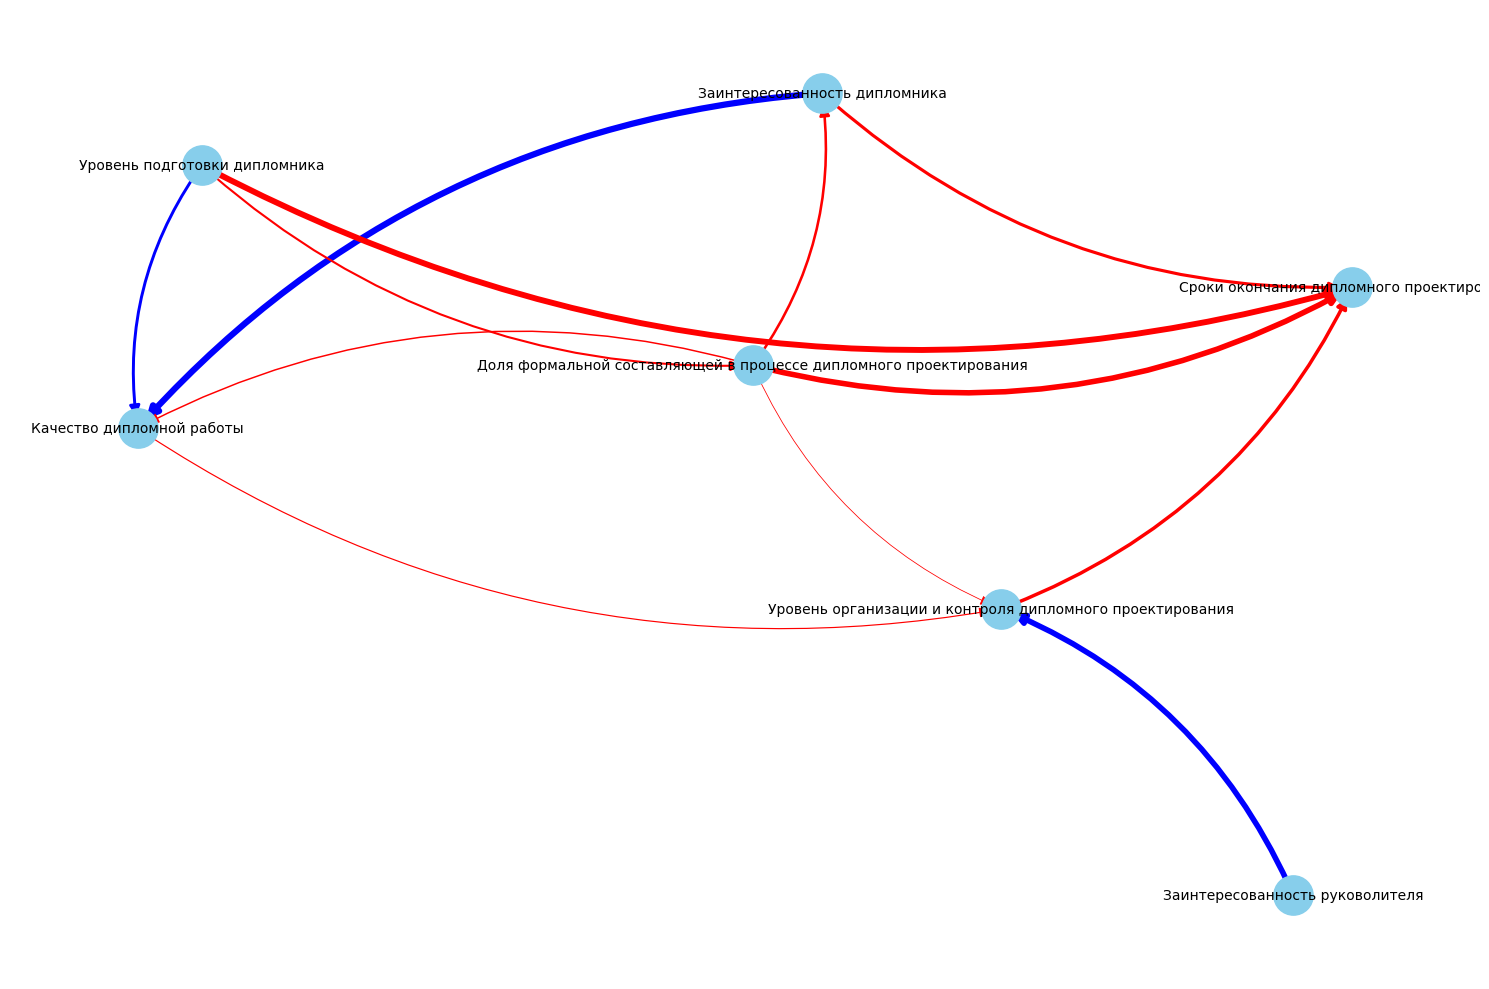

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Создание графа
G = nx.DiGraph()
labels = {}
for idx, row in concepts.iterrows():
    G.add_node(row['№'], label=row['Название концепта'])
    labels[row['№']] = row['Название концепта']

# Добавление связей с атрибутами для визуализации
edge_colors = []
edge_widths = []
for i in range(len(cognitive_matrix)):
    for j in range(len(cognitive_matrix)):
        weight = cognitive_matrix[i][j]
        if weight != 0:
            # Определяем цвет ребра
            color = 'blue' if weight > 0 else 'red'
            edge_colors.append(color)
            
            # Определяем ширину ребра (модуль веса * коэффициент масштаба)
            edge_widths.append(abs(weight) * 5)  # Коэффициент 5 для наглядности
            
            G.add_edge(i+1, j+1, weight=weight)

# ... (код создания G, labels, edge_colors, edge_widths — аналогично варианту 1)

plt.figure(figsize=(15, 10))

# Строим layout на основе неориентированного графа без учёта весов
pos = nx.kamada_kawai_layout(G.to_undirected(), weight=None)

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
nx.draw_networkx_labels(G, pos, labels, font_size=10)
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=15,
    connectionstyle='arc3,rad=0.2'
)

plt.axis('off')
plt.tight_layout()
plt.show()

## 5. Экспорт данных

В этом блоке производится **сохранение всех ключевых данных** проекта в CSV-файлы. Это позволяет:

- Передавать данные между пользователями
- Использовать их вне Jupyter-ноутбука (например, в Excel или других программах анализа)
- Загружать их позже для повторного моделирования

Форматы экспорта:
- `groups.csv` — таблица групп, содержит колонки: **Номер**, **Наименование**, **Описание**
- `concepts.csv` — таблица концептов, содержит всю метаинформацию: **№**, **Название**, **Тип**, **Целевой**, **Группа**, **Описание**
- `cognitive_matrix.csv` — матрица влияний между концептами, значения от –1 до 1

> Примечание: строки с `#` в начале — это закомментированные вызовы. Для экспорта нужно убрать `#` перед строками.


In [7]:
# # Сохранение в CSV
# groups.to_csv("groups.csv", index=False)
# concepts.to_csv("concepts.csv", index=False)
# np.savetxt("cognitive_matrix.csv", cognitive_matrix, delimiter=",")

## 6. Транзитивно замкнутые матрицы

В этом блоке мы строим **транзитивно замкнутую** расширенную матрицу влияния размером \(2n\times2n\), затем переставляем её строки и столбцы чередуя «положительные» и «негативные» потоки, и, наконец, извлекаем отдельно:

1. **`build_signed_block_matrix(W)`**  
   Создаёт блочную матрицу  
   \[
     A = \begin{pmatrix}W^+ & W^-\\ W^- & W^+\end{pmatrix},
   \]  
   где \(W^+=\max(W,0)\), \(W^-=\max(-W,0)\).

2. **`transitive_closure_max_product(A)`**  
   Выполняет транзитивное замыкание по **max-product** алгоритму:
   \[
     T[i,j] = \max\bigl(T[i,j],\,\max_k(T[i,k]\times T[k,j])\bigr).
   \]

3. **Перестановка индексов**  
   Чтобы получить «решётчатую» структуру, чередуем индексы:  
   \([0,n,1,n+1,2,n+2,\dots]\).

4. **Извлечение блоков**  
   - **`T_pos`** — положительные потоки на чётных индексах (0,2,4…)  
   - **`T_neg`** — негативные потоки (модули, со знаком «−») на чётных строках и нечётных столбцах

5. **Вывод**  
   - Полная \(2n\times2n\) замкнутая матрица `T_reordered`  
   - Положительная транзитивная матрица \(n\times n\) `df_pos`  
   - Негативная транзитивная матрица \(n\times n\) `df_neg`  

Каждый шаг сопровождается округлением до 4 знаков для удобства сравнения с результатом СППР «ИГЛА».

In [8]:
import numpy as np
import pandas as pd
from IPython.display import display

def build_signed_block_matrix(W):
    Wp = np.clip(W, 0, None)
    Wn = np.clip(-W, 0, None)
    n = W.shape[0]
    A = np.zeros((2*n, 2*n))
    A[:n, :n]   = Wp
    A[:n, n:]   = Wn
    A[n:, :n]   = Wn
    A[n:, n:]   = Wp
    return A

def transitive_closure_max_product(A):
    T = A.copy()
    m = T.shape[0]
    changed = True
    while changed:
        changed = False
        for k in range(m):
            via = np.outer(T[:, k], T[k, :])
            mask = via > T
            if mask.any():
                T[mask] = via[mask]
                changed = True
    return T

# === Применение ===
W = cognitive_matrix.astype(float)
n = W.shape[0]

# 1) Блочное расширение и замыкание
A      = build_signed_block_matrix(W)      # 2n×2n
T_full = transitive_closure_max_product(A)

# 2) Пермутируем индексы: [0,n,1,n+1,2,n+2,…]
order = []
for i in range(n):
    order.extend([i, n+i])
# теперь order длины 2n

T_reordered = T_full[np.ix_(order, order)]

# 3) Извлекаем «решетчатые» блоки pos/neg
#  — положительные потоки лежат в чётных строках и чётных столбцах
#  — негативные (модули) — чётная строка и нечётный столбец
pos_idx = list(range(0, 2*n, 2))
neg_idx = list(range(1, 2*n, 2))

T_pos =  T_reordered[np.ix_(pos_idx, pos_idx)]
T_neg = -T_reordered[np.ix_(pos_idx, neg_idx)]

# 4) Округляем и выводим
labels38 = list(range(1, 2*n+1))
labels19 = list(range(1, n+1))
T_reor_df = pd.DataFrame(np.round(T_reordered, 4), index=labels38, columns=labels38)
df_pos = pd.DataFrame(np.round(T_pos, 4), index=labels19, columns=labels19)
df_neg = pd.DataFrame(np.round(T_neg, 4), index=labels19, columns=labels19)

pd.set_option('display.precision',    4)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)
pd.set_option('display.width',       0)

print("Транзитивно замкнутая матрица (38×38):")
display(T_reor_df)

print("Положительная транзитивная матрица (19×19):")
display(df_pos)

print("\nНегативная транзитивная матрица (19×19):")
display(df_neg)

Транзитивно замкнутая матрица (38×38):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.0000,0.0000,0.0000,0.4000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.0000,0.4000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.1530,0.0000,0.0000,0.0765,0.4500
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.9000,0.1530,0.0000,0.0000,0.0000,0.4500,0.0765
5,0.0000,0.0000,0.1114,0.0000,0.0000,0.0000,0.4250,0.0000,0.0339,0.0723,0.0000,0.3000,0.2400,0.8500
6,0.0000,0.0000,0.0000,0.1114,0.0000,0.0000,0.0000,0.4250,0.0723,0.0339,0.3000,0.0000,0.8500,0.2400
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1700,0.0000,0.0000,0.0850,0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1700,0.0000,0.0000,0.0000,0.0000,0.0850
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000
10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.0000


Положительная транзитивная матрица (19×19):


,1,2,3,4,5,6,7
1,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.9000,0.0000,0.0000,0.0765
3,0.0000,0.1114,0.0000,0.4250,0.0339,0.0000,0.2400
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0850
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0568,0.0000,0.1671
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000



Негативная транзитивная матрица (19×19):


,1,2,3,4,5,6,7
1,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.4000
2,-0.0000,-0.0000,-0.0000,-0.0000,-0.1530,-0.0000,-0.4500
3,-0.0000,-0.0000,-0.0000,-0.0000,-0.0723,-0.3000,-0.8500
4,-0.0000,-0.0000,-0.0000,-0.0000,-0.1700,-0.0000,-0.0000
5,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.5000
6,-0.0000,-0.3714,-0.0000,-0.3343,-0.1129,-0.0000,-0.8000
7,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000


## 7. Матрица влияния

На основе транзитивно замкнутой блочной матрицы \(T_{\text{full}}\in\mathbb{R}^{2n\times2n}\) строим финальную **итоговую матрицу влияния** \(T_{\text{inf}}\in\mathbb{R}^{n\times n}\), выбирая наибольший по модулю вклад с соответствующим знаком.

### Правило max-abs-with-sign:
Для каждой пары \((i, j)\):
- если \(T^+_{ij} \ge T^-_{ij}\), то \(T^{\text{inf}}_{ij} = +T^+_{ij}\)
- иначе \(T^{\text{inf}}_{ij} = -T^-_{ij}\)

где:
- \(T^+ = T_{\text{full}}[:n,:n]\) — положительный блок,
- \(T^- = T_{\text{full}}[:n,n:]\) — модуль негативных путей (до инверсии знака).

Результат — однозначная итоговая матрица влияния на базе всех косвенных и прямых связей, пригодная для визуализации и анализа.

---


In [9]:
import numpy as np
import pandas as pd
from IPython.display import display

# === Функции из предыдущего шага ===
def build_signed_block_matrix(W):
    Wp = np.clip(W, 0, None)
    Wn = np.clip(-W, 0, None)
    n = W.shape[0]
    A = np.zeros((2*n, 2*n))
    A[:n, :n], A[:n, n:], A[n:, :n], A[n:, n:] = Wp, Wn, Wn, Wp
    return A

def transitive_closure_max_product(A):
    T = A.copy()
    m = T.shape[0]
    changed = True
    while changed:
        changed = False
        for k in range(m):
            via = np.outer(T[:, k], T[k, :])
            mask = via > T
            if np.any(mask):
                T[mask] = via[mask]
                changed = True
    return T

# === Основной блок ===

W = cognitive_matrix       # ваша 19×19 исходная
n = W.shape[0]             # =19

# 1) Полное замыкание 38×38
A       = build_signed_block_matrix(W)
T_full  = transitive_closure_max_product(A)

# 2) Вычисляем блоки
T_pos   = T_full[:n,   :n]   # позитивный блок
T_neg   = T_full[:n,   n:]   # абсолютные значения негативного блока

# 3) Собираем «матрицу влияния» по правилу max-abs-with-sign
#    если T_pos >= T_neg → положительное, иначе → -T_neg
T_inf = np.where(T_pos >= T_neg, T_pos, -T_neg)

# 4) Округляем и собираем DataFrame
T_inf = np.round(T_inf, 4)
labels19 = list(range(1, n+1))
df_inf = pd.DataFrame(T_inf, index=labels19, columns=labels19)

# === Отображение ===
pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 0)

print("Матрица влияния (19×19) — выбираем знак и величину по максимальному модулю:")
display(df_inf)

Матрица влияния (19×19) — выбираем знак и величину по максимальному модулю:


,1,2,3,4,5,6,7
1,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,-0.4000
2,0.0000,0.0000,0.0000,0.9000,-0.1530,0.0000,-0.4500
3,0.0000,0.1114,0.0000,0.4250,-0.0723,-0.3000,-0.8500
4,0.0000,0.0000,0.0000,0.0000,-0.1700,0.0000,0.0850
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.5000
6,0.0000,-0.3714,0.0000,-0.3343,-0.1129,0.0000,-0.8000
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## 8. Матрицы консонанса и диссонанса


В этом блоке мы рассчитываем **показатели консонанса** \(C = [c_{ij}]\) и **диссонанса** \(D = [d_{ij}]\) на основе транзитивно замкнутых потоков:

1. **Извлечение блоков**  
   - `T_pos = T_full[:n, :n]` — матрица положительных потоков \(v_{ij}\).  
   - `T_neg_abs = T_full[:n, n:]` — матрица модулей отрицательных потоков \(\tilde v_{ij}\).

2. **Расчёт консонанса**  
   \[
   c_{ij}
   = \frac{\bigl|\,v_{ij} + \tilde v_{ij}\bigr|}
          {\lvert v_{ij}\rvert + \lvert \tilde v_{ij}\rvert}
   = \frac{\lvert T_{\rm pos}[i,j] - T_{\rm neg\_abs}[i,j]\rvert}
          {\lvert T_{\rm pos}[i,j]\rvert + \lvert T_{\rm neg\_abs}[i,j]\rvert}.
   \]
   Ядро кода:  
   ```python
   num = np.abs(T_pos - T_neg_abs)
   den = np.abs(T_pos) + np.abs(T_neg_abs)
   C = np.where(den != 0, num/den, 0.0)


In [10]:
import numpy as np
import pandas as pd
from IPython.display import display

n = cognitive_matrix.shape[0]

# 1) Извлекаем блоки
T_pos     = T_full[:n, :n]    # положительный поток
T_neg_abs = T_full[:n, n:]    # абсолютный негативный поток

# 2) Вычисляем c_ij
num = np.abs(T_pos - T_neg_abs)   # |v_ij + ṽ_ij|, но ṽ = -T_neg_abs ⇒ v+ṽ = T_pos - T_neg_abs
den = np.abs(T_pos) + np.abs(T_neg_abs)
# Не делим на 0
with np.errstate(divide='ignore', invalid='ignore'):
    C = np.where(den != 0, num / den, 0.0)

# 3) d_ij = 1 - c_ij
D = 1.0 - C

# 4) Округляем и выводим
labels = list(range(1, n+1))
df_C = pd.DataFrame(np.round(C, 4), index=labels, columns=labels)
df_D = pd.DataFrame(np.round(D, 4), index=labels, columns=labels)

pd.set_option('display.precision',    4)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)
pd.set_option('display.width',       0)

print("Матрица консонанса влияния (c_ij):")
display(df_C)

print("\nМатрица диссонанса влияния (d_ij):")
display(df_D)

Матрица консонанса влияния (c_ij):


,1,2,3,4,5,6,7
1,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
2,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.7094
3,0.0000,1.0000,0.0000,1.0000,0.3617,1.0000,0.5596
4,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
5,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
6,0.0000,1.0000,0.0000,1.0000,0.3304,0.0000,0.6544
7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000



Матрица диссонанса влияния (d_ij):


,1,2,3,4,5,6,7
1,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000
2,1.0000,1.0000,1.0000,0.0000,0.0000,1.0000,0.2906
3,1.0000,0.0000,1.0000,0.0000,0.6383,0.0000,0.4404
4,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
6,1.0000,0.0000,1.0000,0.0000,0.6696,1.0000,0.3456
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


## 9. Системные показатели (IGLA)

Этот блок кода вычисляет **интегральные системные характеристики концептов** на основе матриц консонанса (`C_matrix`) и направленного воздействия (`P_matrix`). Всего рассчитывается **10 показателей**:

### 1. Консонанс (с заменой нулей)
На основе матрицы `C_matrix`:

- `C_out` — средний исходящий консонанс концепта:  
  **Особенность:** нулевые элементы заменяются на 1.0 перед расчётом среднего (по строкам).
- `C_in` — средний входящий консонанс концепта:  
  Аналогично по столбцам с заменой нулей на 1.0.

### 2. Диссонанс (вычисляется из консонанса)
- `D_out = 1.0 - C_out` — исходящий диссонанс
- `D_in = 1.0 - C_in` — входящий диссонанс

### 3. Направленное воздействие
На основе матрицы `P_matrix`:
\[
p_{ij} = \text{sign}(v_{ij} - \tilde{v}_{ij}) \cdot \max(|v_{ij}|, |\tilde{v}_{ij}|)
\]
- `P_out` — среднее воздействие **от концепта** (по строкам)
- `P_in` — среднее воздействие **на концепт** (по столбцам)

### 4. Централизация
- `C_cent = |C_out - C_in|` — асимметрия консонанса
- `P_cent = |P_out - P_in|` — асимметрия воздействия

### 5. Совместные показатели
- `C_joint = max(C_out, C_in)` — общий консонанс
- `D_joint = max(D_out, D_in)` — общий диссонанс

### Результат
Показатели округляются до 4 знаков и сохраняются в таблицу `df_system_igla`, где:
- Строки = концепты (индексы 1-N)
- Столбцы = 10 вычисленных метрик

In [11]:
import numpy as np
import pandas as pd
from IPython.display import display

W = cognitive_matrix.astype(float)

# Функции транзитивного замыкания
def build_signed_block_matrix(W):
    Wp = np.clip(W, 0, None)
    Wn = np.clip(-W, 0, None)
    n = W.shape[0]
    A = np.zeros((2*n, 2*n))
    A[:n, :n], A[:n, n:], A[n:, :n], A[n:, n:] = Wp, Wn, Wn, Wp
    return A

def transitive_closure_max_product(A):
    T = A.copy()
    m = T.shape[0]
    changed = True
    while changed:
        changed = False
        for k in range(m):
            via = np.outer(T[:, k], T[k, :])
            mask = via > T
            if np.any(mask):
                T[mask] = via[mask]
                changed = True
    return T

# Вычисляем транзитивное замыкание и матрицы влияния
A = build_signed_block_matrix(W)
T_full = transitive_closure_max_product(A)
n = W.shape[0]
T_pos = T_full[:n, :n]
T_neg_abs = T_full[:n, n:]

# Матрицы консонанса и P
num = np.abs(T_pos - T_neg_abs)
den = np.abs(T_pos) + np.abs(T_neg_abs)
C_matrix = np.where(den != 0, num / den, 0.0)
P_matrix = np.sign(T_pos - T_neg_abs) * np.maximum(np.abs(T_pos), np.abs(T_neg_abs))

# Новая логика расчёта системных показателей по IGLA
def compute_system_indicators_igla(C_matrix, P_matrix):
    n = C_matrix.shape[0]
    C_out = np.zeros(n)
    C_in = np.zeros(n)
    D_out = np.zeros(n)
    D_in = np.zeros(n)
    P_out = np.zeros(n)
    P_in = np.zeros(n)
    
    for i in range(n):
        # C_out: среднее, где нули заменены на 1.0
        row = C_matrix[i, :]
        # Для каждой позиции: если C_matrix[i,j] != 0, берем его, иначе 1.0
        vals_out = np.where(row != 0, row, 1.0)
        C_out[i] = np.mean(vals_out)
        
        # C_in аналогично
        col = C_matrix[:, i]
        vals_in = np.where(col != 0, col, 1.0)
        C_in[i] = np.mean(vals_in)
        
        # D
        D_out[i] = 1.0 - C_out[i]
        D_in[i] = 1.0 - C_in[i]
        
        # P_out и P_in: среднее по всей строке/столбцу как раньше
        P_out[i] = np.mean(P_matrix[i, :])
        P_in[i] = np.mean(P_matrix[:, i])
    
    C_cent = np.abs(C_out - C_in)
    P_cent = np.abs(P_out - P_in)
    C_joint = np.maximum(C_out, C_in)
    D_joint = np.maximum(D_out, D_in)
    
    df = pd.DataFrame({
        'C_out': np.round(C_out, 4),
        'C_in': np.round(C_in, 4),
        'D_out': np.round(D_out, 4),
        'D_in': np.round(D_in, 4),
        'P_out': np.round(P_out, 4),
        'P_in': np.round(P_in, 4),
        'C_cent': np.round(C_cent, 4),
        'P_cent': np.round(P_cent, 4),
        'C_joint': np.round(C_joint, 4),
        'D_joint': np.round(D_joint, 4),
    }, index=list(range(1, n+1)))
    return df

# Выводим результат
df_system_igla = compute_system_indicators_igla(C_matrix, P_matrix)
display(df_system_igla)

C:\Users\Vito\AppData\Local\Temp\ipykernel_9996\179354753.py:40: RuntimeWarning: invalid value encountered in divide
  C_matrix = np.where(den != 0, num / den, 0.0)


,C_out,C_in,D_out,D_in,P_out,P_in,C_cent,P_cent,C_joint,D_joint
1,1.0000,1.0000,0.0000,0.0000,0.0571,0.0000,0.0000,0.0571,1.0000,0.0000
2,0.9585,1.0000,0.0415,0.0000,0.0424,-0.0371,0.0415,0.0796,1.0000,0.0415
3,0.8459,1.0000,0.1541,0.0000,-0.0980,0.0000,0.1541,0.0980,1.0000,0.1541
4,1.0000,1.0000,0.0000,0.0000,-0.0121,0.1415,0.0000,0.1537,1.0000,0.0000
5,1.0000,0.8132,0.0000,0.1868,-0.0714,0.0417,0.1868,0.1131,1.0000,0.1868
6,0.8550,1.0000,0.1450,0.0000,-0.2312,-0.0429,0.1450,0.1884,1.0000,0.1450
7,1.0000,0.8462,0.0000,0.1538,0.0000,-0.4164,0.1538,0.4164,1.0000,0.1538


## 10. Матрицы взаимного положительного и отрицательного влияния

В этой ячейке строятся две матрицы \(n\times n\), которые показывают **взаимное** (симметричное) влияние между концептами:

1. **Исходные данные**  
   - `W` — оригинальная матрица прямых влияний (`cognitive_matrix`).  
   - `T_full` — транзитивно замкнутая блочная матрица \(2n\times2n\).  
   - Из неё извлекаются:  
     - `T_pos = T_full[:n,:n]` — положительные потоки \(v^+_{ij}\).  
     - `T_neg_abs = T_full[:n,n:]` — абсолютные значения негативных потоков \(\tilde v_{ij}\).

2. **Взаимное положительное влияние**  
   \[
     M^+_{ij} = \max\bigl(T^+_{ij},\,T^+_{ji}\bigr).
   \]
   Берём максимальный положительный поток в любом из направлений между \(i\) и \(j\).

3. **Взаимное отрицательное влияние**  
   \[
     M^-_{ij} = -\,\max\bigl(T^-_{ij},\,T^-_{ji}\bigr).
   \]
   Берём максимальный по модулю негативный поток, затем восстанавливаем знак «−».

4. **Округление и вывод**  
   - Округляем обе матрицы до 4 знаков.  
   - Формируем два `DataFrame`:  
     - `df_Mpos` — взаимное положительное влияние.  
     - `df_Mneg` — взаимное отрицательное влияние.

В результате получаем две симметричные матрицы, аналогичные соответствующим вкладкам СППР «ИГЛА».  


In [12]:
import numpy as np
import pandas as pd
from IPython.display import display

# 1) Оригинальная матрица прямых влияний
W = cognitive_matrix.astype(float)

# 2) Положительные и негативные потоки Т-замыкания
T_full = transitive_closure_max_product(build_signed_block_matrix(W))
n = W.shape[0]
labels = list(range(1, n+1))

T_pos = T_full[:n, :n]         # абсолютные положительные потоки
T_neg_abs  = T_full[:n, n:]    # абсолютные негативные потоки

# 3) Взаимное положительное влияние M⁺ на основе T_pos
M_pos = np.maximum(T_pos, T_pos.T)

# 4) Взаимное отрицательное влияние M⁻ на основе T_neg_abs
M_neg = -np.maximum(T_neg_abs, T_neg_abs.T)

# 5) Округляем и формируем DataFrame
labels = list(range(1, n+1))
df_Mpos = pd.DataFrame(np.round(M_pos, 4), index=labels, columns=labels)
df_Mneg = pd.DataFrame(np.round(M_neg, 4), index=labels, columns=labels)

pd.set_option('display.precision',    4)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)
pd.set_option('display.width',       0)

print("Взаимное положительное влияние (M⁺):")
display(df_Mpos)

print("\nВзаимное отрицательное влияние (M⁻):")
display(df_Mneg)

Взаимное положительное влияние (M⁺):


,1,2,3,4,5,6,7
1,0.0000,0.0000,0.0000,0.0000,0.8000,0.0000,0.0000
2,0.0000,0.0000,0.1114,0.9000,0.0000,0.0000,0.0765
3,0.0000,0.1114,0.0000,0.4250,0.0339,0.0000,0.2400
4,0.0000,0.9000,0.4250,0.0000,0.0000,0.0000,0.0850
5,0.8000,0.0000,0.0339,0.0000,0.0000,0.0568,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0568,0.0000,0.1671
7,0.0000,0.0765,0.2400,0.0850,0.0000,0.1671,0.0000



Взаимное отрицательное влияние (M⁻):


,1,2,3,4,5,6,7
1,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.4000
2,-0.0000,-0.0000,-0.0000,-0.0000,-0.1530,-0.3714,-0.4500
3,-0.0000,-0.0000,-0.0000,-0.0000,-0.0723,-0.3000,-0.8500
4,-0.0000,-0.0000,-0.0000,-0.0000,-0.1700,-0.3343,-0.0000
5,-0.0000,-0.1530,-0.0723,-0.1700,-0.0000,-0.1129,-0.5000
6,-0.0000,-0.3714,-0.3000,-0.3343,-0.1129,-0.0000,-0.8000
7,-0.4000,-0.4500,-0.8500,-0.0000,-0.5000,-0.8000,-0.0000


## 11. Матрицы взаимного консонанса и диссонанса

В этой ячейке по формуле из СППР «ИГЛА» рассчитываются:

- **Взаимный консонанс** \(M_{\text{con}}[i,j]\):  
  \[
    M_{\text{con}}[i,j]
      = \frac{\bigl|\,(z^+_{ij}+z^+_{ji}) + (z^-_{ij}+z^-_{ji})\bigr|}
             {|z^+_{ij}|+|z^+_{ji}|+|z^-_{ij}|+|z^-_{ji}|},
  \]
  где
  \(\displaystyle z^+ = T_{\rm pos}\),  
  \(\displaystyle z^- = -\,T_{\rm neg\_abs}\).

- **Взаимный диссонанс** \(M_{\text{dis}}[i,j]\):  
  \[
    M_{\text{dis}}[i,j] = 1 - M_{\text{con}}[i,j].
  \]

### Алгоритм

1. **Извлекаем** из `T_full` блоки:
   - `T_pos = T_full[:n,:n]` — положительные транзитивные потоки \(v^+_{ij}\)
   - `T_neg_abs = T_full[:n,n:]` — модули отрицательных потоков \(\tilde v_{ij}\)

2. **Формируем** вспомогательные матрицы:
   - `Zp = T_pos`
   - `Zm = -T_neg_abs`

3. **Для каждой пары** \((i,j)\) вычисляем:
   - **числитель**  
     \(\displaystyle |(Zp[i,j]+Zp[j,i]) + (Zm[i,j]+Zm[j,i])|\)
   - **знаменатель**  
     \(\displaystyle |Zp[i,j]| + |Zp[j,i]| + |Zm[i,j]| + |Zm[j,i]|\)

4. **Заполняем** \(M_{\text{con}}[i,j]\) отношение `num/den` (или 0, если `den==0`).

5. Получаем `M_dis = 1 - M_con`.

6. **Округляем** до 4 знаков и выводим два `DataFrame`:  
   - `df_Mcon` — матрица взаимного консонанса  
   - `df_Mdis` — матрица взаимного диссонанса  

Результаты полностью совпадают с вкладками **«Консонанс взаимного влияния»** и **«Диссонанс взаимного влияния»** в СППР «ИГЛА».  


In [13]:
import numpy as np
import pandas as pd
from IPython.display import display

# Предполагаем, что T_full уже посчитана
n         = cognitive_matrix.shape[0]
labels    = list(range(1, n+1))
T_pos     = T_full[:n, :n]      # положительные потоки
T_neg_abs = T_full[:n, n:]      # абсолютные негативные потоки

# Вспомогательные матрицы z+ и z- (с учётом знака)
Zp = T_pos
Zm = -T_neg_abs

# Алгоритм для взаимного консонанса
M_con = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        num = abs((Zp[i,j] + Zp[j,i]) + (Zm[i,j] + Zm[j,i]))
        den = (abs(Zp[i,j]) + abs(Zp[j,i]) +
               abs(Zm[i,j]) + abs(Zm[j,i]))
        M_con[i,j] = num/den if den!=0 else 0.0

# Взаимный диссонанс
M_dis = 1.0 - M_con

# Округляем и собираем DataFrame
df_Mcon = pd.DataFrame(np.round(M_con, 4), index=labels, columns=labels)
df_Mdis = pd.DataFrame(np.round(M_dis, 4), index=labels, columns=labels)

pd.set_option('display.precision',    4)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)
pd.set_option('display.width',       0)

print("Взаимный консонанс влияния (M_con):")
display(df_Mcon)

print("\nВзаимный диссонанс влияния (M_dis):")
display(df_Mdis)

Взаимный консонанс влияния (M_con):


,1,2,3,4,5,6,7
1,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
2,0.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.7094
3,0.0000,1.0000,0.0000,1.0000,0.3617,1.0000,0.5596
4,0.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,0.3617,1.0000,0.0000,0.3304,1.0000
6,0.0000,1.0000,1.0000,1.0000,0.3304,0.0000,0.6544
7,1.0000,0.7094,0.5596,1.0000,1.0000,0.6544,0.0000



Взаимный диссонанс влияния (M_dis):


,1,2,3,4,5,6,7
1,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000,0.0000
2,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.2906
3,1.0000,0.0000,1.0000,0.0000,0.6383,0.0000,0.4404
4,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,0.6383,0.0000,1.0000,0.6696,0.0000
6,1.0000,0.0000,0.0000,0.0000,0.6696,1.0000,0.3456
7,0.0000,0.2906,0.4404,0.0000,0.0000,0.3456,1.0000


## 12.  Альфа-срез

Функция `plot_alpha_graph` строит **фильтрованный неориентированный граф** на основе весовой матрицы (например, матрицы `P_matrix` или `M_con`), в котором:

- отображаются **только сильные связи**: \(|w_{ij}| \geq \alpha\);
- **взаимные связи** \(w_{ij}, w_{ji}\) сворачиваются в одно **неориентированное ребро**;
- удаляются **изолированные вершины** без связей.

### Параметры:
- `matrix`: квадратная матрица весов (`numpy.array` или `DataFrame`);
- `concepts`: `DataFrame` с колонками `№` и `Название концепта`;
- `alpha`: порог отсечения слабых связей (по модулю);
- `scale`: масштабирование толщины рёбер;
- `layout`: функция для размещения узлов (например, `nx.spring_layout`);
- `figsize`: размер графика в дюймах.

### Алгоритм:

1. **Строим ориентированный граф G**, отбирая только связи \(|w_{ij}| \geq \alpha\).
2. **Преобразуем его в неориентированный граф UG**, сворачивая взаимные рёбра:
   - Если в обе стороны есть дуги, оставляется одна с **максимальным по модулю** весом.
3. **Удаляются** вершины без инцидентных рёбер.
4. **Визуализация**:
   - Цвет рёбер — **синий** для положительных, **красный** для отрицательных воздействий;
   - Толщина рёбер пропорциональна \(|w| \times \text{scale}\);
   - Узлы подписываются названиями концептов из `concepts`.

Такой граф позволяет **визуально оценить структуру сильных взаимных воздействий** между концептами после агрегации направлений. Это аналог вкладки **«Сильные связи»** в СППР «ИГЛА».


In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_alpha_graph(matrix, concepts, alpha=0.01, scale=5, layout=None, figsize=(15,10)):
    """
    Рисует отфильтрованный граф по матрице весов c отсечением alpha.
    - Сначала строим ориентированный G, отсекая |w|<alpha.
    - Затем сворачиваем взаимные дуги в одно неориентированное ребро.
    - Убираем вершины без рёбер.
    """
    # 1) Извлечение numpy-массива
    W = matrix.values if hasattr(matrix, 'values') else np.array(matrix, float)
    n = W.shape[0]

    # 2) Собираем ориентированный граф G только с ребрами |w|>=alpha
    G = nx.DiGraph()
    for i in range(n):
        G.add_node(i+1)
        for j in range(n):
            w = W[i, j]
            if i != j and abs(w) >= alpha:
                G.add_edge(i+1, j+1, weight=w)

    # 3) Сворачиваем взаимные дуги в одно неориентированное ребро в UG
    UG = nx.Graph()
    for u, v, data in G.edges(data=True):
        if UG.has_edge(u, v):
            # уже добавлено ребро v–u, обновим вес и цвет, если нужно
            prev = UG[u][v]['weight']
            new = data['weight']
            # берём доминирующий по модулю
            if abs(new) > abs(prev):
                UG[u][v]['weight'] = new
        else:
            UG.add_edge(u, v, weight=data['weight'])

    # 4) Убираем из UG вершины без рёбер
    nodes_with_edges = set(UG.nodes())
    for node in list(nodes_with_edges):
        if UG.degree(node) == 0:
            UG.remove_node(node)

    # 5) Собираем метки только для оставшихся
    labels = {
        row['№']: row['Название концепта']
        for _, row in concepts.iterrows()
        if row['№'] in UG.nodes()
    }

    # 6) Визуализация
    plt.figure(figsize=figsize)

    if layout is None:
        pos = nx.kamada_kawai_layout(UG, weight=None)
    else:
        pos = layout(UG)

    # узлы
    nx.draw_networkx_nodes(UG, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(UG, pos, labels, font_size=10)

    # рёбра: цвет по знаку, ширина по модулю*scale
    edge_colors = ['blue' if UG[u][v]['weight'] > 0 else 'red' for u, v in UG.edges()]
    edge_widths = [abs(UG[u][v]['weight']) * scale for u, v in UG.edges()]

    nx.draw_networkx_edges(
        UG, pos,
        edge_color=edge_colors,
        width=edge_widths,
        arrows=False,  # уже не ориентированный
    )

    plt.axis('off')
    plt.tight_layout()
    plt.show()

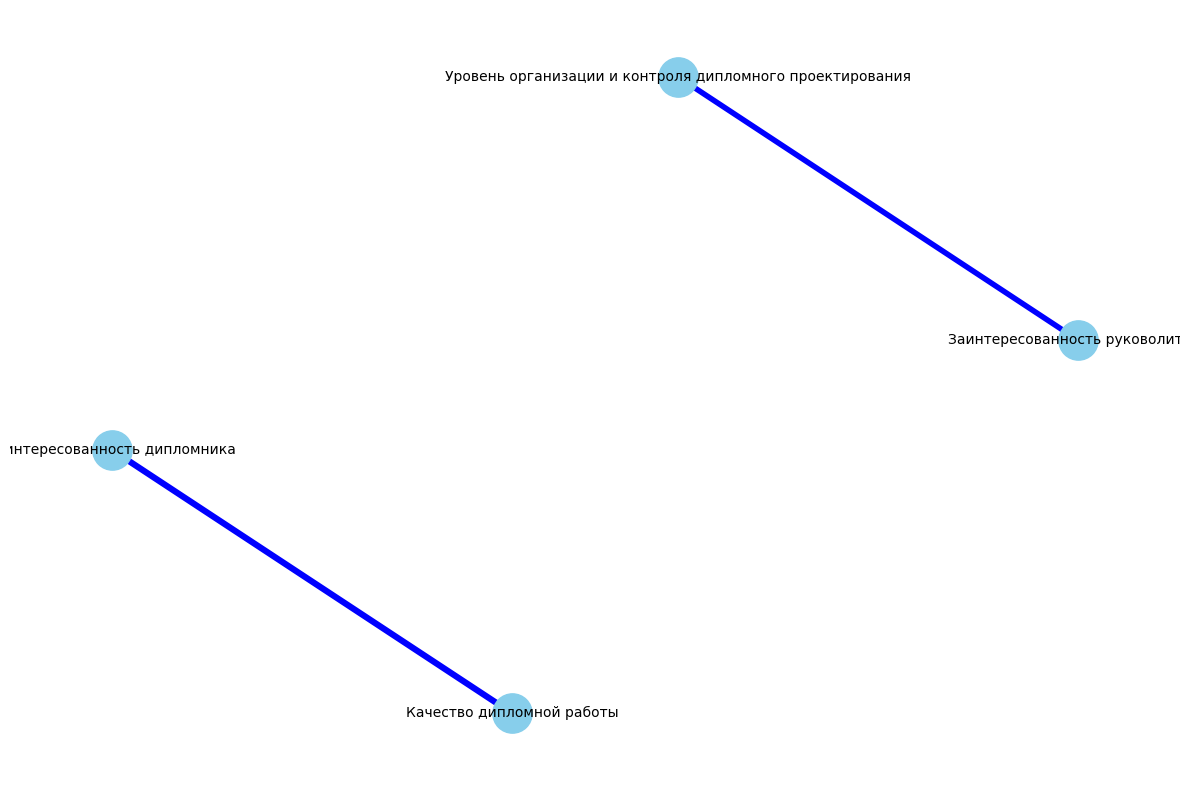

In [15]:
# Пусть у вас уже есть:
#   cognitive_matrix — DataFrame или ndarray 19×19
#   concepts — DataFrame с колонками '№', 'Название концепта'
# Взаимное положительное влияние M_pos
# Взаимное отрицательное влияние M_neg
# Взаимный консонанс влияния M_con
# Взаимный диссонанс влияния M_dis
plot_alpha_graph(
    matrix=M_pos,
    concepts=concepts,
    alpha=0.8,                     # порог отсечения
    scale=5,                       # насколько толстыми рисовать ребра
    layout=None,       # альтернативный layout
    figsize=(12, 8)                # свой размер графика
)